In [1]:
from keras.preprocessing.sequence import pad_sequences
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

#Параллельно выполняющийся map функции func по массиву massive
def parallelization(func,massive,tq = True):
    
    num_cores = 20 #multiprocessing.cpu_count() # Число наших ядер
    if tq:
        results = np.array(Parallel(n_jobs=num_cores)(delayed(func)(i) for i in tqdm(massive)))
        return results
    else:
        results = Parallel(n_jobs=num_cores)(delayed(func)(i) for i in massive)
        return results

Using TensorFlow backend.


In [2]:
import pandas as pd
import re
import pymorphy2
import numpy as np
from collections import Counter


morph = pymorphy2.MorphAnalyzer()

def _word2canonical4w2v(word):
    elems = morph.parse(word)
    my_tag = ''
    res = []
    for elem in elems:
            if 'VERB' in elem.tag or 'GRND' in elem.tag or 'INFN' in elem.tag:
                    my_tag = 'V'
            if 'NOUN' in elem.tag:
                    my_tag = 'S'
            normalised = elem.normalized.word
            if my_tag == '':
                    res.append((normalised, ''))
            res.append((normalised, my_tag))
    tmp = list(filter(lambda x: x[1] != '', res))
    if len(tmp) > 0:
        return tmp[0]
    else:
        return res[0]

    
def word2canonical(word):
    return _word2canonical4w2v(word)[0]


def getWords(text, filter_short_words=False):
    if filter_short_words:
        return filter(lambda x: len(x) > 3, re.findall(r'(?u)\w+', text))
    else:
        return re.findall(r'(?u)\w+', text)


def text2canonicals(text, add_word=False, filter_short_words=True):
    words = []
    for word in getWords(text, filter_short_words = filter_short_words):
            words.append(word2canonical(word.lower()))
            if add_word:
                    words.append(word.lower())
    return words

In [3]:
from bs4 import BeautifulSoup

def remove_tags(text):
    soup = BeautifulSoup(text,'html.parser')
    return soup.text

def convert_text(text):
    text = text2canonicals(remove_tags(text).lower())# убираем тэги и переводим в lower-case
    return text

def formatting(word):
    index_ = word.find('_')
    return word[:index_]

In [5]:
import pandas as pd
import numpy as np
data = pd.read_csv('Ponyland/headhunter_sallary.txt.proper.csv')
data = data[data['salary:currency'] == 'RUR']
data = data[((data['salary:to'] > 100) & (data['salary:to'] <  440000)) 
                & ((data['salary:from'] > 100) & (data['salary:to'] <  440000))]
    

In [6]:
texts = parallelization(convert_text,data.description.values,True)

100%|██████████| 161544/161544 [12:48<00:00, 210.19it/s]


In [7]:
texts = map(lambda x: ' '.join(x),texts) 
texts = map(lambda x: x.encode('utf8'), texts)

In [8]:
def get_mean_length(texts):
    cnt = 0
    
    lengths = []
    for text in texts:
        lengths.append(len(text.split()))
        cnt += 1
    return lengths #sum(lengths)/float(cnt), max(lengths), min(lengths), 

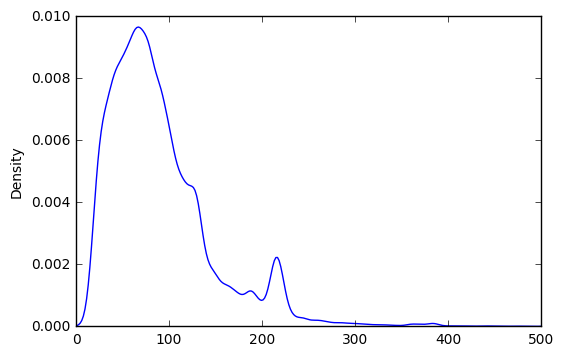

In [9]:
lengths = get_mean_length(texts)
import matplotlib.pyplot as plt
%matplotlib inline
plt.axis((0,500,0,0.010))
pd.Series(lengths).plot(kind ='kde')

In [10]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(nb_words=200000)  
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) 

word_index = tokenizer.word_index


In [11]:
print word_index.keys()[1210]
print word_index['data']

петропаловка
4445


In [12]:
from gensim import models

model = models.Word2Vec.load_word2vec_format('Ponyland/ruwikiruscorpora.model.bin', binary=True)
new_keys =  map(lambda x: formatting(x[0]), model.vocab.items())
values = model.vocab.values()
new_dict = dict(zip(new_keys, values))
model.vocab = new_dict

In [13]:
cnt = 0
embedding_matrix = np.zeros((len(word_index) + 1, 500)) # делаем веса для embedding-слоя 

# итереруемся по всем уникальным словам из наших текстов и их индексам, которые сделал токенайзер
for word, i in word_index.items(): 
    try:
        embedding_vector = model[word.decode('utf8')] # для слова берем те самые 100 значений из словаря
        embedding_matrix[i] = embedding_vector
  
    except KeyError:
        
        cnt += 1
        if cnt <= 100:
            print word

        continue

print cnt

usiness
mbizglobal
габишева
coreanimation
дисциплиныорганизация
мосжиларенда
40часовая
xunit
экструзионна
фаерволл
project818
аккуратнов
kaspersky
fancybox
перепискиskype
screaming
близлежайший
сеттуа
kinnevik
receiving
rabbitmq
заявокнаша
шёлковый
наш
magneex
feasibility
фискас
19970
msmagazine
sustaining
мачуга
срок0
36700
basegroup
hairbeautyclub
компанииподробность
трёхмесячный
документооборотаусловие
азопиирамов
сп䍕циальность
designing
17250
cветотехник
gmsite
motorolla
сталепромышленна
сайтен
оалтуфьево
звёздочка
tyllipad
зазнаться
эсмо
рашау
мониитооринг
прособеседован
golder
низкомаржинальный
санпина3
наказать
транспортазнание
saifi
пункт䐺льнocть
туризмекто
mesmerize
exce
сегметация
мелкоузловая
блогмама
circumstances
заказпереключение
emmepilight
13050
cussons
hyatt
оп䎺䐪
titanium
мясырьё
miele
pinta
котлопункт
контрактинг
cadency
со䌞седование
avfoundation
actionscript
essie
филёнчатый
ночьсмена
докопаться
23500
oтpыв
экскизов
сластёна
arderia
диаконт
мероприятияостальная
dessa

In [16]:
from DatasetCreation import *
import pickle as pkl
data, y = make_dataset('data_with_important_features.csv',True,x = False,y = True,chunks =20)

x = pkl.load(open('Ponyland/X_text.pkl','rb'))

In [19]:
left_edge = np.mean(y)-3*np.std(y)
right_edge = np.mean(y) + 3*np.std(y)

In [ ]:
pkl.dump(embedding_matrix,open('EMBEDDING.pkl', 'wb'))
pkl.dump(tokenizer, open('TOKENIZER.pkl','wb'))

# Сетка

In [20]:
%env THEANO_FLAGS="device=gpu"
import theano

env: THEANO_FLAGS="device=gpu"


Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


In [22]:
from sklearn.cross_validation import train_test_split

In [23]:
def apply_ohe(target):
    nb_cl = max(target)+1
    matrix = []

    for i in range(len(target)):
        mas = np.zeros(nb_cl)
        index = target[i]

        mas[index] = 1
        matrix.append(mas)
        
    return np.array(matrix)

In [24]:
from collections import Counter

length = float(data.shape[0]) 
weights = Counter()
for cl in y:
    weights[cl] += 1
    
values = np.array(weights.values())
keys = np.array(weights.keys())

new_values = 1 - values/length

class_weights = dict(zip(keys, new_values))

class_weights

{0: 0.90731936809785574,
 1: 0.62860273362056152,
 2: 0.74592061605506865,
 3: 0.86522557321844207,
 4: 0.93487223295201305,
 5: 0.97486133808745601,
 6: 0.96872678651017674,
 7: 0.99822339424553064,
 8: 0.99872480562571186,
 9: 0.99327118308324669,
 10: 0.9986443321943248,
 11: 0.99640345664339125,
 12: 0.99971524785816868,
 13: 0.99075174565443469,
 14: 0.99980810181746149,
 15: 0.99961001337097011,
 16: 0.99996285841628285,
 17: 0.99995047788837721,
 18: 0.99943049571633735,
 19: 0.9999752389441886}

In [25]:
y = apply_ohe(y)

X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.1,random_state=42)

embedding_matrix = pkl.load(open('EMBEDDING.pkl','rb'))

embedding_matrix.astype('float32')

MAX_TEXT_LEN = 200
W2VEC_SIZE = 500
NUM_EMB_WORDS = embedding_matrix.shape[0]


In [27]:
from keras.models import Sequential,load_model
from keras.layers import Dense,LSTM,Dropout
from keras.layers import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.metrics import accuracy_score
from keras.regularizers import l1l2

model = Sequential()

model.add(Embedding(NUM_EMB_WORDS, W2VEC_SIZE, input_length=MAX_TEXT_LEN, weights=[embedding_matrix]))

model.add(Conv1D(64,3,activation='tanh'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64,3,activation='tanh'))
model.add(MaxPooling1D(3))


model.add(LSTM(128, return_sequences=True,go_backwards=True,W_regularizer=l1l2(0.000005,0.000005),b_regularizer=l1l2(0.000005,0.000005)))
model.add(Dropout(0.1))

model.add(LSTM(128,W_regularizer=l1l2(0.000005,0.000005),b_regularizer=l1l2(0.000005,0.000005)))
model.add(Dropout(0.1))

model.add(Dense(20, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.fit(X_train,y_train,batch_size=512,nb_epoch=1,validation_data=[X_val,y_val],class_weight=class_weights)
model.save_weights('Ponyland/weights0_64.h5')
model.save('Ponyland/model0_64.h5')

# Результаты

In [28]:
def get_true_classes(pred):
    true_classes = []
    for row in pred:
        cl = np.zeros(20)
        index_of_max = row.argmax()

        cl[index_of_max] = 1

        true_classes.append(cl)
    true_classes = np.array(true_classes)
    return true_classes

In [30]:
model.load_weights('Ponyland/weights0_64.h5')

In [31]:
train_pred = model.predict_proba(X_train)
true_pred_train = get_true_classes(train_pred)

test_pred = model.predict_proba(X_val)
true_pred_test = get_true_classes(test_pred)

16155/16155 [==============================] - 14s    


In [32]:
pkl.dump(train_pred, open('Ponyland/X_train_pred.pkl','wb'))
pkl.dump(test_pred, open('Ponyland/X_test_pred.pkl','wb'))

In [33]:
pd.DataFrame({'accuracy':[accuracy_score(y_train,true_pred_train),
              accuracy_score(y_val,true_pred_test)]}, index=['train','test'])


,accuracy
train,0.665607
test,0.642402


## Файлик, который можно импортить и быстро получать train и test сеты

In [ ]:
%%writefile DatasetCreation.py

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from joblib import Parallel, delayed
import re
import pymorphy2
import multiprocessing
from tqdm import tqdm
import pickle
from keras.preprocessing.sequence import pad_sequences

tokenizer = pickle.load(open('TOKENIZER.pkl','rb'))
morph = pymorphy2.MorphAnalyzer()

def _word2canonical4w2v(word):
    elems =  morph.parse(word)
    my_tag = ''
    res = []
    for elem in elems:
            if 'VERB' in elem.tag or 'GRND' in elem.tag or 'INFN' in elem.tag:
                    my_tag = 'V'
            if 'NOUN' in elem.tag:
                    my_tag = 'S'
            normalised = elem.normalized.word
            if my_tag == '':
                    res.append((normalised, ''))
            res.append((normalised, my_tag))
    tmp = list(filter(lambda x: x[1] != '', res))
    if len(tmp) > 0:
        return tmp[0]
    else:
        return res[0]


def word2canonical(word):
    return  _word2canonical4w2v(word)[0]


def getWords(text, filter_short_words=False):
    if filter_short_words:
        return filter(lambda x: len(x) > 3, re.findall(r'(?u)\w+', text))
    else:
        return re.findall(r'(?u)\w+', text)


def text2canonicals(text, add_word=False, filter_short_words=True):
    words = []
    for word in getWords(text, filter_short_words = filter_short_words):
        words.append(word2canonical(word.lower()))
        if add_word:
            words.append(word.lower())
    return words


def remove_tags(text):
    soup = BeautifulSoup(text,'html.parser')
    return soup.text


def convert_text(text):
    text = text2canonicals(remove_tags(text).lower())
    return text


def parallelization(massive,tq = True):    
    num_cores = 20#multiprocessing.cpu_count()
    if tq:
        results = np.array(Parallel(n_jobs=num_cores)(delayed(convert_text)(i) for i in tqdm(massive)))
        return results
    else:
        results = Parallel(n_jobs=num_cores)(delayed(convert_text)(i) for i in massive)
        return results

    
def make_classes(y, nb_classes):
    chunk_size = 440000/nb_classes
    y = np.array(map(int,y))/chunk_size
    return y    


def make_dataset(path,df=True,x=False,y=False, chunks = False):
    data = pd.read_csv(path,index_col=False)
    data = data[data['salary:currency'] == 'RUR'] 
    data = data[((data['salary:to'] > 100) & (data['salary:to'] <  440000)) 
                & ((data['salary:from'] > 100) & (data['salary:to'] <  440000))]
    
    to_return = []
    
    if df == True:
        to_return.append(data)
    
    if x == True:
        texts = parallelization(data.description.values,True)
        texts = map(lambda x: ' '.join(x),texts) 
        texts = map(lambda x: x.encode('utf8'), texts)

        sequences = tokenizer.texts_to_sequences(texts) 
        X = pad_sequences(sequences, maxlen=200) 
        to_return.append(X)


    if y == True:
        sal_to = data['salary:to']; sal_from = data['salary:from']
        Y = np.array([max(sal_to.iloc[i],sal_from.iloc[i]) for i in range(len(sal_to))])
        
        if chunks != False:
            Y = make_classes(Y,chunks)
            
        to_return.append(Y)
        

    return tuple(to_return)
